<a href="https://colab.research.google.com/github/miltonospina/cv-level-sensor/blob/main/CV_shut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#required libraries
import cv2
import numpy as np

#required only for notebook demo
from google.colab.patches import cv2_imshow
import urllib.request

In [2]:
#CONSTANTS
HSV_GREEN_LOW = (36, 30, 0)
HSV_GREEN_HIGH = (70, 255, 255)
WINDOW_WIDTH = 400
WINDOW_HEIGHT = 2100
CROP_PERCENTAGE = 0.05
HSL_WHITE_LOW = np.array([0,160,0])
HSL_WHITE_HIGH = np.array([255,255,255])

In [3]:
#pretty image show
def cv2_imshow_rz(titulo,image,h_esperado = 400):
  print(titulo)
  (ih, iw) = image.shape[:2]
  escala = h_esperado/ih
  nh = int(ih * escala)
  nw = int(iw * escala)
  resized = cv2.resize(image ,( nw, nh))
  cv2_imshow( resized )

Original


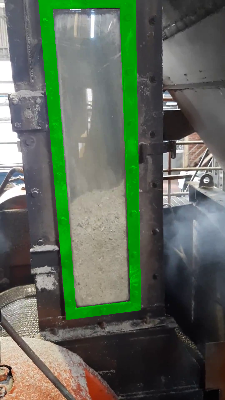

In [4]:
#download image from github
url_image = 'https://user-images.githubusercontent.com/7133629/125175478-15136700-e192-11eb-9087-a3a4090f6b39.png'
url_response = urllib.request.urlopen(url_image)
img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)

original_image = cv2.imdecode(img_array, -1)
cv2_imshow_rz("Original",original_image)

In [5]:
def frame_detection(bgr_image, hsv_low, hsv_high):
  # convierte la imagen a hsv
  hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
  # crea la mascara verde
  frame_image = cv2.inRange(hsv_image, hsv_low, hsv_high)

  #Deteccion de contornos
  contours, hierarchy = cv2.findContours(frame_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  max_arcLen = 0
  innerContour = 0
  window_frame = 0
  #por cada uno de los contornos; normalmenre son 2
  for contour in contours:
      arcLen = cv2.arcLength(contour, True)
      if arcLen > max_arcLen:
          max_arcLen = cv2.arcLength(contour, True)
      if arcLen > 100:
          if innerContour > arcLen:
              innerContour = arcLen
          if innerContour == 0:
              innerContour = arcLen
          epsilon = 0.01*cv2.arcLength(contour, True)
          approx = cv2.approxPolyDP(contour, epsilon, True)
          x = approx.ravel()[0]
          y = approx.ravel()[1]
          if len(approx) == 4:
              x, y, w, h = cv2.boundingRect(approx)
              aspectRatio = float(w)/h
              if innerContour == arcLen:
                  window_frame = approx
  return frame_image, window_frame

Imagen del marco


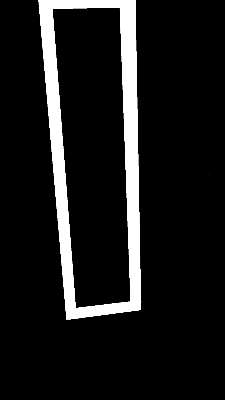

In [6]:
frame_image, window_shape = frame_detection(original_image, HSV_GREEN_LOW, HSV_GREEN_HIGH)
cv2_imshow_rz("Imagen del marco", frame_image)

In [7]:
#identificar los puntos para recorte
def window_cut_and_transform(image, window_shape,window_width,window_height):
  p1 = window_shape[3][0]
  p2 = window_shape[0][0]
  p3 = window_shape[2][0]
  p4 = window_shape[1][0]

  #calula la matriz de distorsion
  distorted_shape = np.float32([p1,p2,p3,p4])
  corrected_shape = np.float32([[0,0],[window_width,0],[0,window_height],[window_width,window_height]])
  MAP_MATRIX = cv2.getPerspectiveTransform(distorted_shape,corrected_shape)

  #retorna la imagen recortada y transformada
  return cv2.warpPerspective(image,MAP_MATRIX,(window_width,window_height))

transformada


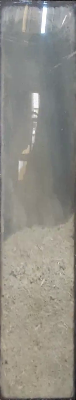

In [8]:
transformed_image = window_cut_and_transform(original_image, window_shape,WINDOW_WIDTH,WINDOW_HEIGHT)
cv2_imshow_rz("transformada", transformed_image)

In [9]:
#aplicar un recorte al rectangulo 
def border_crop(image, crop_percentage):
  (h,w) = image.shape[:2]
  r0y = int(crop_percentage * h)
  rny = int(crop_percentage * (1-h))
  r0x = int(crop_percentage * w)
  rnx = int(crop_percentage * (1-w))

  return image[r0y:rny, r0x:rnx]

crop % a la transformada


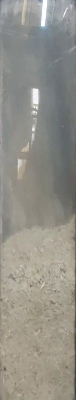

In [10]:
cropped_image = border_crop(transformed_image, CROP_PERCENTAGE)
cv2_imshow_rz("crop % a la transformada", cropped_image)

In [11]:
def image_clahe(image):
  hist,bins = np.histogram(image.flatten(),256,[0,256])
  cdf = hist.cumsum()
  cdf_normalized = cdf * hist.max()/ cdf.max()
  cdf_m = np.ma.masked_equal(cdf,0)
  cdf_m2 = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
  cdf2 = np.ma.filled(cdf_m2,0).astype('uint8')
  return cdf2[image]

Equalización de histogramas


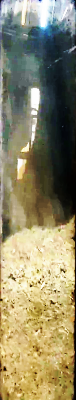

In [12]:
clahe_image = image_clahe(cropped_image)
cv2_imshow_rz("Equalización de histogramas",clahe_image)

In [13]:
# detecta el las imagenees en un rango de blancos
def detect_glare(image, hsl_white_low, hsl_white_high):

  blurred_image = cv2.GaussianBlur(image, (9,9), cv2.BORDER_TRANSPARENT)
  hsl_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2HLS)

  return cv2.inRange(hsl_image,hsl_white_low , hsl_white_high)

Separa solo lo blanco


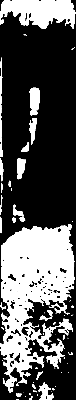

In [14]:
white_mask_image = detect_glare(clahe_image, HSL_WHITE_LOW, HSL_WHITE_HIGH)
cv2_imshow_rz("Separa solo lo blanco", white_mask_image)

In [15]:
def find_largest_rectangle(image):
  contours, hierarchy = cv2.findContours(image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  
  ct_brillo = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  try: hierarchy = hierarchy[0]
  except: hierarchy = []
  
  height, width = image.shape
  (xM,yM,wM,hM) =(0,0,0,0)

  result_image = np.zeros((height,width,3), np.uint8)

  for idx, contour in enumerate(contours):
    (x,y,w,h) = cv2.boundingRect(contour)
    result_image = cv2.rectangle(result_image, (x, y), (x+w, y+h), (127, 127, 127), -1)
    if wM * hM == 0 or wM* hM < w*h :
      (xM,yM,wM,hM) = (x,y,w,h)

  area_total = height * width
  area_ocupada = (wM* hM)
  level = (area_ocupada/ area_total)*100

  
  result_image = cv2.rectangle(result_image, (xM, yM), (xM+wM, yM+hM), (127, 255, 0), -1)

  return level, result_image

41.52161175463109%


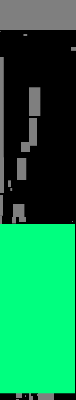

In [16]:
chute_level, final_image = find_largest_rectangle(white_mask_image)
cv2_imshow_rz(f"{chute_level}%", final_image )